In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import matplotlib.pyplot as plt
import seaborn

import os
import glob

import numpy as np
import math

import datetime, time
from datetime import datetime



import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
import os
import plotly
import plotly.express as ex
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [2]:
def plotVelocity(df, time="Date"):
    fig, ax = plt.subplots()
    ax.plot([getTimestamp(x.Date) for x in df.select(time).collect()], [x.velocity for x in df.select('velocity').collect()] )
    
def plotFigure(df, time="Date", velocity="velocity"):
    x = df.select(time).toPandas()[time]
    y = df.select(velocity).toPandas()[velocity]
    fig = go.Figure([go.Scatter(x=x, y=y)])
    fig.show()
    
def plotMap(dataframe):
    temp = dataframe.toPandas()
    
    fig = ex.scatter_mapbox(
        temp, lat=temp['Latitude'], 
        lon=temp['Longitude'], 
        zoom=10, 
        opacity=1, 
        size_max=20, 
        title="GeoTagging", 
        width=1200, 
        height =800, 
        template="plotly_dark", 
        hover_data=['Date'])
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show() 

In [3]:
def instAcc(df):
    dy = np.diff(
        np.array([x.velocity for x in df.select('velocity').collect()]
    ))
    
    time = np.array([datetime.timestamp(x.timestamp) for x in df.select('timestamp').collect()])
    dx = np.diff(time)
    dy_dx = dy/dx
    xprime = []
    for i in range(len(dy)-1):
        xtemp = (time[i+1] + time[i])/2
        xprime = np.append(xprime, xtemp)
        
    end_pad = time[len(time)-1] +(time[len(time)-1]-time[len(time)-2])
    xtemp = 0.5*(end_pad + time[len(time)-1])
    xprime = np.append(xprime, xtemp)
    return xprime, dy_dx



def central_difference(x, y):
    
    h = x[1] - x[0]
    diff = [
        (y[1]-y[0])/(x[1]-(x[0]-h))
    ]
    
    for i in range(1, len(y)-1):
        temp = (y[i+1]-y[i-1])/(x[i+1]-x[i-1])
        diff = np.append(diff, temp)
    
    h = x[len(y)-1] - x[len(y)-2]
    diff = np.append(
        diff,
        (y[len(y)-1]-y[len(y)-2])/((x[len(y)-1]+h)-x[len(y)-2])
    )
    
    return x, diff

def getTimeVelocity(df): 
    time = [x.Date for x in df.select("Date").collect()]
    velocity = [x.velocity for x in df.select('velocity').collect()]
    return time, velocity


def instAcceleration(df, time="Date", velocity="velocity"):
    time, velocity = [(x.time, x.velocity) for x in df.select([time, velocity]).collect()]
    
    

In [4]:
def rad(d):
    return float(d)*math.pi/180

def getDistance(lat1, long1, lat2, long2):
    r = 6378
    a = rad(lat2) - rad(lat1)
    b = rad(long2) - rad(long1)
    
    a = math.pow(math.sin(a/2), 2) + math.pow(math.sin(b/2), 2)*math.cos(lat1)*math.cos(lat2)
    c = 2*math.asin(math.sqrt(a))   
    return r*c
def getCoordinates(df):
    latitude = [x.latitude for x in df.select('latitude').collect()]
    longitude = [ x.longitude for x in df.select( 'longitude').collect()]
    return latitude, longitude 

def meanCoordinate(lat, long, i, j):
    amount = j-i+1
    
    if amount ==0:
        return float(lat[i]), float(long[i])
    
    sumLat = 0
    sumLong = 0
    
    for k in range(i, j+1):
        sumLat += float(lat[k])
        sumLong += float(long[k])
        
    return sumLat/amount, sumLong/amount


def deltaTime(dates, i, j):
    return datetime.timestamp(dates[j])- datetime.timestamp(dates[i])

def StayPoint_Detection(df, distThresh, timeThresh):
    lat, long = getCoordinates(df)
    dates = [x.Date for  x  in df.select("Date").collect()]
    
    N = df.count()
    SP = []
    i = 0
    while i < N:
        j = i + 1
        Token = 0
        while j < N:
            distance = getDistance(lat[i], long[i], lat[j], long[j])
            if distance > float(distThresh):
                if deltaTime(dates, i, j) > timeThresh:
                    S_lat, S_long = meanCoordinate(lat, long, i , j-1)
                    t_arrive = dates[i].strftime("%Y/%m/%d, %H:%M:%S")
                    t_depart = dates[j-1].strftime("%Y/%m/%d, %H:%M:%S")
                    SP.append([S_lat, S_long, t_arrive, t_depart, [i, j-1]])
                    i = j
                    Token = 1
                break
            j+=1
        if Token != 1:
            i += 1
    return SP
    
    

In [5]:
spark = SparkSession.builder.appName("App").getOrCreate()

In [6]:
data_dir = 'D:\\Telematics\\Car Track\\Data'
data_dir

'D:\\Telematics\\Car Track\\Data'

In [7]:
os.listdir(data_dir)

['CA641377-2022-08-01-23_21_41-2022-08-01-23_47_00.csv']

In [8]:
df = spark.read.csv(os.path.join(data_dir, os.listdir(data_dir)[0]), inferSchema=True, header=True, sep=";")

In [9]:
df.printSchema()
df.count()

root
 |-- Events: string (nullable = true)
 |-- Vision Events: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Speed: integer (nullable = true)
 |-- Road Speed: integer (nullable = true)
 |-- Odometer: string (nullable = true)
 |-- Linear G: string (nullable = true)
 |-- Lateral G: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Geofences: string (nullable = true)



137

In [10]:
df_clean = df.drop("Events", "Vision Events", "Geofences", "Location", "Odometer", "Linear G", "Lateral G", "Road Speed").dropDuplicates().sort("Date").withColumnRenamed("Speed", "velocity")

df_clean.count()

136

In [11]:
def getTimestamp(DT: datetime):
    return datetime.timestamp(DT)

def getTimestampArr(arr : list):
    return [datetime.timestamp(x) for x in arr]

In [ ]:
getTimestamp(df_clean.select("Date").take(1)[0].Date)

In [ ]:
diff = np.diff([getTimestamp(x.Date) for x in df_clean.select("Date").collect()])

In [ ]:
plotVelocity(df_clean)

In [ ]:
plotFigure(df_clean)

In [ ]:
plotMap(df_clean)

In [12]:
lat, long = getCoordinates(df_clean)

dates = [x.Date for  x  in df.select("Date").collect()]
    
N = df.count()
SP = []
distThresh = 100/1000
timeThresh = 50

In [ ]:
i = 0
while i < N:
    j = i + 1
    Token = 0
    while j < N:
        distance = getDistance(lat[i], long[i], lat[j], long[j])
        print("Distance: ", distance)
        dt = deltaTime(dates, i, j)
        print("Delta t: ", dt)
        '''
        if distance > float(distThresh):
            
             
            print("Delta t: ", dt)
             
            if dt > timeThresh:
                S_lat, S_long = meanCoordinate(lat, long, i , j-1)
                t_arrive = dates[i].strftime("%Y/%m/%d, %H:%M:%S")
                t_depart = dates[j-1].strftime("%Y/%m/%d, %H:%M:%S")
                SP.append([S_lat, S_long, t_arrive, t_depart, [i, j-1]])
                i = j
                Token = 1
            break
            '''
        j+=1
    i +=1

In [ ]:
total = 0
for i in range(len(lat)-1):
    print("Distances (m)", getDistance(lat[i], long[i], lat[i+1], long[i+1])*1000)
    total += getDistance(lat[i], long[i], lat[i+1], long[i+1])
    #print("dT", deltaTime(dates, i, i+1))
    
print(total)

In [ ]:
distThresh

In [ ]:
dates

In [ ]:
pd = df_clean.toPandas()

pd = pd.set_index('Date')

In [ ]:
df_clean.show()

In [ ]:
pd.resample('10s').ffill().dropna()

In [ ]:
pd = pd.resample('10s').ffill().dropna()
pd.head(n=50)

In [ ]:
clean = spark.createDataFrame(pd)

In [ ]:
clean.show()

In [ ]:
small = pd.head(n=10)
small = small.reset_index()
small

In [ ]:
time = [datetime.timestamp(x) for x in dates]
velocity = [x.velocity for x in df_clean.select('velocity').collect()]

In [ ]:
velocity

In [ ]:
_, y= central_difference(time, velocity)
fig = go.Figure([go.Scatter(x=dates, y=y)])
fig.show()

In [ ]:
len(y)

In [ ]:
Cd = 0.33
A = 1.45*1.78
m = 1300
mu = 0.02
theta = 0
p = 1.2754
g = 9.8
def Fd(m, a, v, mu, Cd, A, theta):
    p = 1.2754
    g = 9.8
    return (0.5*p*Cd*A*math.pow(v,2) + mu*m*g*math.cos(theta) + m*g*math.sin(theta)+m*a)
power = 0
for i in range(len(y)):
    power += (Fd(m, y[i], velocity[i]/3.6, mu, Cd, A, 0)*(velocity[i]/3.6))
    print((Fd(m, y[i], velocity[i]/3.6, mu, Cd, A, 0)*(velocity[i]/3.6))/1000)
    print("Drag: ",0.5*p*Cd*A*math.pow(velocity[i],2))
    print( "Fricton roll: ", mu*m*g*math.cos(theta))
    print("Friction: ", m*g*math.sin(theta))
    print("Inertia: ",m*y[i])
    print(f'Velocity: {velocity[i]}')
    print(f'Acceleration: {y[i]}')
    print()

In [ ]:
power = np.array([ (Fd(m, y[i], velocity[i]/3.6, mu, Cd, A, 0)*(velocity[i]/3.6)) for i in range(len(y))]
                 ,dtype=float)

In [ ]:
power

In [ ]:

fig = go.Figure([go.Scatter(x=dates, y=power)])
fig.show()

In [ ]:
y

In [ ]:
def unevenTrap(y, t):
    area = []
    total = 0
    dT = np.diff(t)
    for i in range(len(y)-1):
        temp = (y[i] + y[i+1])*dT[i]/2
        total += temp
        area = np.append(area, temp)
        
    return area, total

In [ ]:
t = getTimestampArr(dates)

a, b = unevenTrap(power, t)

b

In [ ]:
b/(1000*3600)

In [13]:
group = df_clean.withColumn("Minute", minute(df_clean.Date)).groupBy('Minute', window("Date", "10 seconds")).agg(
    mean("velocity").alias("grouped_velocity"), 
    expr("collect_list(velocity)").alias("velocity list")
)

In [14]:
group.count()

115

In [15]:
df_resampled = group.withColumn("Start", group.window.start).withColumn("End", group.window.end).sort("Start")
df_resampled = df_resampled.withColumn("Date",from_unixtime((unix_timestamp(df_resampled.Start) + unix_timestamp(df_resampled.End))/2, "yyyy-MM-dd HH:mm:ss"))


In [16]:
df_resampled.show()

+------+--------------------+----------------+-------------+-------------------+-------------------+-------------------+
|Minute|              window|grouped_velocity|velocity list|              Start|                End|               Date|
+------+--------------------+----------------+-------------+-------------------+-------------------+-------------------+
|    21|{2022-08-01 23:21...|             0.0|       [0, 0]|2022-08-01 23:21:40|2022-08-01 23:21:50|2022-08-01 23:21:45|
|    23|{2022-08-01 23:23...|            15.0|     [13, 17]|2022-08-01 23:23:00|2022-08-01 23:23:10|2022-08-01 23:23:05|
|    23|{2022-08-01 23:23...|            39.0|         [39]|2022-08-01 23:23:10|2022-08-01 23:23:20|2022-08-01 23:23:15|
|    23|{2022-08-01 23:23...|            46.0|         [46]|2022-08-01 23:23:20|2022-08-01 23:23:30|2022-08-01 23:23:25|
|    23|{2022-08-01 23:23...|            48.0|         [48]|2022-08-01 23:23:40|2022-08-01 23:23:50|2022-08-01 23:23:45|
|    23|{2022-08-01 23:23...|   

In [17]:
v_clean = df_resampled.select(["Date", "Start", "End", "grouped_velocity"]).withColumnRenamed("grouped_velocity", "velocity")

In [ ]:
np.diff(np.array([datetime.strptime(x.Ave, "%Y-%m-%d %H:%M:%S") for x in df_resampled.select("Ave").collect()]))




In [18]:
v_clean = v_clean.withColumn("Date", to_timestamp(v_clean.Date, "yyyy-MM-dd HH:mm:ss"))

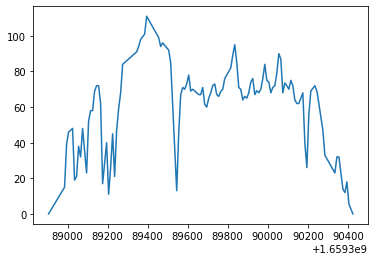

In [19]:
plotVelocity(v_clean)

In [22]:
dates

[1659388905.0,
 1659388985.0,
 1659388995.0,
 1659389005.0,
 1659389025.0,
 1659389035.0,
 1659389045.0,
 1659389055.0,
 1659389065.0,
 1659389075.0,
 1659389095.0,
 1659389105.0,
 1659389115.0,
 1659389125.0,
 1659389135.0,
 1659389145.0,
 1659389155.0,
 1659389165.0,
 1659389175.0,
 1659389195.0,
 1659389205.0,
 1659389215.0,
 1659389225.0,
 1659389235.0,
 1659389245.0,
 1659389255.0,
 1659389265.0,
 1659389275.0,
 1659389345.0,
 1659389355.0,
 1659389365.0,
 1659389385.0,
 1659389395.0,
 1659389455.0,
 1659389465.0,
 1659389475.0,
 1659389505.0,
 1659389515.0,
 1659389545.0,
 1659389555.0,
 1659389565.0,
 1659389575.0,
 1659389585.0,
 1659389595.0,
 1659389605.0,
 1659389615.0,
 1659389625.0,
 1659389655.0,
 1659389665.0,
 1659389675.0,
 1659389685.0,
 1659389695.0,
 1659389705.0,
 1659389715.0,
 1659389725.0,
 1659389735.0,
 1659389745.0,
 1659389755.0,
 1659389765.0,
 1659389775.0,
 1659389785.0,
 1659389805.0,
 1659389815.0,
 1659389825.0,
 1659389835.0,
 1659389845.0,
 165938985

In [37]:
diff = np.diff([getTimestamp(x.Date) for x in v_clean.select("Date").collect()])
dates = [getTimestamp(x.Date) for x in v_clean.select("Date").collect()]

In [38]:
for i, td in enumerate(diff):
    if td > 10:
        timeInfo.append([i, td/10])

In [99]:
np.array(timeInfo)[:,0]+8

array([  8.,  11.,  17.,  26.,  35.,  38.,  40.,  43.,  45.,  54.,  68.,
       104., 109., 112., 114., 117., 121.])

In [76]:
time = list(np.copy(dates))

In [77]:
inserts = []
for x in timeInfo:
    i, d = x[0], x[1]
    start = time[i]
    end = time[i+1]
    #print(f'start {start} | end {end}')
    temp = start
    row = []
    for j in range(int(d)-1):
        temp += 10
        row.append(temp)
    inserts.append(row)

In [78]:
def insertList(_list,i, insertee):
    j = i 
    for x in insertee:
        _list.insert(j, x)
        print(j)
        j+=1
        
    return _list

In [79]:
a  = [1, 2, 3]
b = [0, 4]

insertList(b, 1, a )

1
2
3


[0, 1, 2, 3, 4]

In [87]:
d = 0
for i,x in enumerate(inserts):
    a = timeInfo[i][0] + 1
    j = a + d
    print(a)
    #time = insertList(time, j, x)
    d = len(x)
    print(a+d)
    

1
8
4
5
10
11
19
20
28
34
31
32
33
38
36
38
38
40
47
49
61
62
97
98
102
103
105
106
107
111
110
111
114
115


In [91]:
timeInfo[:]

[[0, 8.0],
 [3, 2.0],
 [9, 2.0],
 [18, 2.0],
 [27, 7.0],
 [30, 2.0],
 [32, 6.0],
 [35, 3.0],
 [37, 3.0],
 [46, 3.0],
 [60, 2.0],
 [96, 2.0],
 [101, 2.0],
 [104, 2.0],
 [106, 5.0],
 [109, 2.0],
 [113, 2.0]]

In [74]:
len(time)

267

In [83]:
np.diff(dates)

array([80., 10., 10., 20., 10., 10., 10., 10., 10., 20., 10., 10., 10.,
       10., 10., 10., 10., 10., 20., 10., 10., 10., 10., 10., 10., 10.,
       10., 70., 10., 10., 20., 10., 60., 10., 10., 30., 10., 30., 10.,
       10., 10., 10., 10., 10., 10., 10., 30., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 20., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 20., 10., 10., 10., 10., 20., 10., 10.,
       20., 10., 50., 10., 10., 20., 10., 10., 10., 20.])

In [ ]:
def updateTimeInfo(timeInfo, d):
    timeInfo[:,0] = timeInfo[:,0] + d 
    